In [1]:
import jax.numpy as jnp
import jax.ops
import scipy as scipy
import scipy.integrate
import scipy.optimize
from jax import jit
from functools import partial
import numpy as np
from jax.experimental.ode import odeint
from ticktack import load_presaved_model, Box, Flow, CarbonBoxModel
import numpy as np
from ticktack import fitting
from tqdm import tqdm
import matplotlib.pyplot as plt
from jax_cosmo.scipy.interpolate import InterpolatedUnivariateSpline
from jax.lax import cond, dynamic_update_slice, fori_loop, dynamic_slice, sub
import matplotlib as mpl
from jax import jit, grad, jacrev, vmap
mpl.style.use('seaborn-colorblind')

In [2]:
# @partial(jit, static_argnums=(0, 5, 6))
def reconstruct_production_rate(sf, d14c, t_in, t_out, steady_state_solution, steady_state_production=None,
                                    target_C_14=None):

        data = d14c / 1000 * steady_state_solution[sf.box_idx] + steady_state_solution[sf.box_idx]
        first1 = jnp.where(sf.growth == 1, size=1)[0][0]
        first0 = jnp.where(sf.growth == 0, size=1)[0][0]
        all1s = jnp.where(sf.growth == 1, size=12)[0]
        after1 = jnp.where(all1s > first0, all1s, 0)
        after1 = after1.at[jnp.nonzero(after1, size=1)].get()[0]
        num = sub(first1, after1)
        val = cond(num == 0, lambda x: first1, lambda x: after1, num)
        act = cond(jnp.all(sf.growth == 1), lambda x: 0, lambda x: val, sf.growth)
        act = act + jnp.count_nonzero(sf.growth)/2
        t_in = t_in + act / 12

        dash = lambda x: sf.dash(x,t_in,data)

        # @jit
        def derivative(y, time):
            ans = jnp.matmul(sf.cbm.get_matrix(), y)
            prod_coeff = sf.cbm.get_production_coefficients()
            production_rate = (dash(time) - ans[sf.box_idx]) / prod_coeff[sf.box_idx]
            production_term = prod_coeff * production_rate
            return ans + production_term

        if target_C_14 is not None:
            steady_state = sf.cbm.equilibrate(production_rate=self.cbm.equilibrate(target_C_14=target_C_14))
        elif steady_state_production is not None:
            steady_state = sf.cbm.equilibrate(production_rate=steady_state_production)
        else:
            raise ValueError("Must give either target C-14 or production rate.")

        states = odeint(derivative, steady_state, t_out, atol=1e-15, rtol=1e-15)

        flows = jnp.matmul(sf.cbm.get_matrix(), states.T)
        return sf._reverse_convert_production_rate((vmap(dash)(t_out) - flows[sf.box_idx, :]) /
                                                sf.cbm.get_production_coefficients()[sf.box_idx])

def MC_reconstruct(sf, iters=1000, t_in=None, t_out=None):
        if t_in is None:
            t_in = jnp.zeros((sf.time_data.size + 1))
            t_in = t_in.at[jnp.arange(sf.time_data.size + 1)[1:]].set(sf.time_data)
            t_in = t_in.at[0].set(sf.start - 1)

        if t_out is None:
            t_out = sf.time_data.astype('float64')

        production_rates = []

        for _ in tqdm(range(iters)):
            new_data = sf.d14c_data - sf.offset
            new_data = jnp.concatenate((jnp.expand_dims(jnp.array(new_data[0]), axis=0), new_data))
            prod_recon = reconstruct_production_rate(sf, new_data, t_in, t_out, sf.steady_state_y0,
                                                          steady_state_production=sf.steady_state_production)
            production_rates.append(prod_recon)

        chain = np.array(production_rates)
        return chain

In [3]:
# @partial(jit, static_argnums=(0, 5, 6))
def reconstruct_production_rate_cbm(cbm, d14c, t_in, t_out, steady_state_solution,steady_state_production=None,
                                    target_C_14=None, growth=None):

        data = d14c / 1000 * steady_state_solution[1] + steady_state_solution[1]
        first1 = jnp.where(growth == 1, size=1)[0][0]
        first0 = jnp.where(growth == 0, size=1)[0][0]
        all1s = jnp.where(growth == 1, size=12)[0]
        after1 = jnp.where(all1s > first0, all1s, 0)
        after1 = after1.at[jnp.nonzero(after1, size=1)].get()[0]
        num = sub(first1, after1)
        val = cond(num == 0, lambda x: first1, lambda x: after1, num)
        act = cond(jnp.all(growth == 1), lambda x: 0, lambda x: val, growth)
        act = act + jnp.count_nonzero(growth)/2
        t_in = t_in + act / 12        
    
        @jit
        def interp(time):
            fn = lambda x:InterpolatedUnivariateSpline(t_in, data)(time)
            return fn


        dash = jit(grad(interp))
        
        #@partial(jit, static_argnums=(0))
        def _reverse_convert_production_rate(cbm, production_rate):
            if cbm._production_rate_units == 'atoms/cm^2/s':
                new_rate = production_rate/(14.003242 / 6.022 * 5.11 * 31536. / 1.e5)
            elif cbm._production_rate_units == 'kg/yr':
                new_rate = production_rate
            return new_rate
        


        # @jit
        def derivative(y, time):
            ans = jnp.matmul(cbm.get_matrix(), y)
            prod_coeff = cbm.get_production_coefficients()
            production_rate = (dash(time) - ans[1]) / prod_coeff[1]
            production_term = prod_coeff * production_rate
            return ans + production_term

        if target_C_14 is not None:
            steady_state = cbm.equilibrate(production_rate=self.cbm.equilibrate(target_C_14=target_C_14))
        elif steady_state_production is not None:
            steady_state = cbm.equilibrate(production_rate=steady_state_production)
        else:
            raise ValueError("Must give either target C-14 or production rate.")

        states = odeint(derivative, steady_state, t_out, atol=1e-15, rtol=1e-15)

        flows = jnp.matmul(cbm.get_matrix(), states.T)
        return _reverse_convert_production_rate(cbm,(vmap(dash)(t_out) - flows[1, :]) /
                                                cbm.get_production_coefficients()[1])



# Simulated data Code

In [4]:
cbm = load_presaved_model('Guttler15', production_rate_units='atoms/cm^2/s')
cbm.compile()

start = 760
stop = 801
resolution = 1000
steady_state_burn_in = cbm.equilibrate(target_C_14=707)
t = np.linspace(start,stop,resolution*np.abs(stop-start))
dt = t[1]-t[0]
coarse = np.linspace(760, 800,800-760+1)
steady_state = cbm.equilibrate(production_rate=steady_state_burn_in)

INFO[2022-03-04 09:11:06,927]: Unable to initialize backend 'tpu_driver': Not found: Unable to find driver in registry given worker: 
INFO[2022-03-04 09:11:06,933]: Unable to initialize backend 'gpu': Not found: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
INFO[2022-03-04 09:11:06,941]: Unable to initialize backend 'tpu': Invalid argument: TpuPlatform is not available.
WARNING[2022-03-04 09:11:06,973]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [5]:
@jit
def bump(t):
    return steady_state_burn_in+ 0.05*jnp.exp(-((t-775.)/2.)**2.)


def sg(t, start_time, duration, area):
    middle = start_time + duration / 2.
    height = area / duration
    return height * jnp.exp(- ((t - middle) / (1. / 1.88349 * duration)) ** 8.)


def miyake_event(t, start_time, duration, phase, area):
    height = sg(t, start_time, duration, area)
    prod = steady_state_burn_in + 0.18 * steady_state_burn_in * jnp.sin(2 * np.pi / 11 * t + phase) + height
    return prod

In [6]:
event, _ = cbm.run(t, miyake_event, y0=steady_state, args=(775, 1 / 12, np.pi / 2, 81 / 12), solution=steady_state, steady_state_production=steady_state_burn_in)
data = event[:,1]

In [7]:
vals = cbm.bin_data(data,1000,coarse,growth=jnp.array([0,0,0,1,1,1,1,1,1,0,0,0]))
vals = (vals - steady_state[1])/steady_state[1]*1000
# plt.plot(coarse, vals, 'o') 
# plt.show()

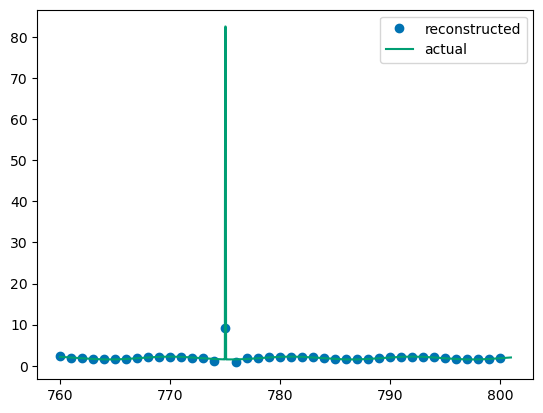

In [8]:
reconstructed = reconstruct_production_rate_cbm(cbm,vals,coarse, coarse,steady_state, steady_state_production=steady_state_burn_in,
                                               growth=jnp.array([0,0,0,1,1,1,1,1,1,0,0,0]))

plt.plot(coarse,reconstructed, 'o')
# plt.xlim([774, 777])
plt.plot(t,miyake_event(t, 775, 1 / 12, np.pi / 2, 81 / 12)) 
plt.legend(["reconstructed", "actual"])
plt.show()

In [11]:
def tt(time, aa, time_d):
    return InterpolatedUnivariateSpline(time_d,aa)(time)

event, _ = cbm.run(t, tt, y0=steady_state, args=(reconstructed,coarse), solution=steady_state, steady_state_production=steady_state_burn_in)
data = event[:,1]
vals2 = cbm.bin_data(data,1000,coarse,growth=jnp.array([0,0,0,1,1,1,1,1,1,0,0,0]))
vals2 = (vals2 - steady_state[1])/steady_state[1]*1000

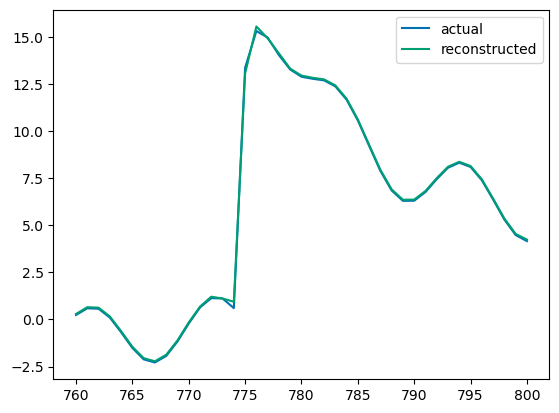

In [12]:
plt.plot(coarse, vals) 
plt.plot(coarse, vals2) 
plt.legend(['actual', 'reconstructed'])
plt.show()

# Real Data

In [19]:
sf = fitting.SingleFitter('Guttler15', 'Guttler15')
sf.load_data("993AD.csv")

In [14]:
vals = sf.d14c_data
time_data = sf.time_data.astype('float64')
reconstructed = reconstruct_production_rate_cbm(sf.cbm,vals,time_data, time_data,steady_state, steady_state_production=steady_state_burn_in,
                                               growth=sf.growth)


In [15]:
def tt(time, aa, time_d):
    return InterpolatedUnivariateSpline(time_d,aa)(time)

t = np.linspace(sf.start,sf.end,int(resolution*np.abs(sf.end-sf.start)))
event, _ = cbm.run(t, tt, y0=steady_state, args=(reconstructed,sf.time_data), solution=steady_state, steady_state_production=steady_state_burn_in)
data = event[:,1]
vals2 = cbm.bin_data(data,1000,sf.time_data,growth=sf.growth)
vals2 = (vals2 - steady_state[1])/steady_state[1]*1000

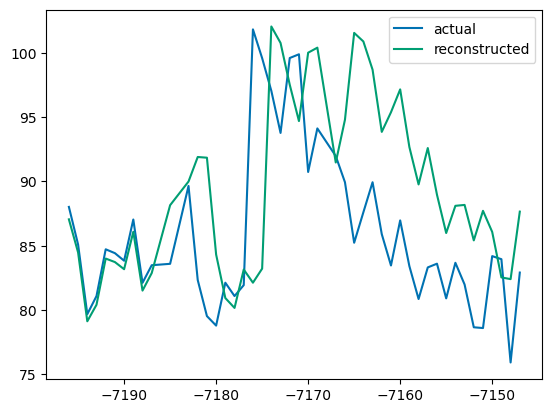

In [16]:
plt.plot(sf.time_data, vals) 
plt.plot(sf.time_data, vals2 + sf.offset) 
plt.legend(['actual', 'reconstructed'])
plt.show()

# Experimentation

In [37]:
data = jnp.array([-21.616813, -19.22474038, -18.36672282, -17.17158763,-19.60010122, -19.16817244, -16.39502499, -17.4707737 ,
             -17.2734855 , -17.03365051, -19.35003231, -19.05371102,  -21.29680925, -22.14494902, -19.42942741, -19.83131721,
             -18.44152562, -19.86152692, -19.67425906, -21.79100714, -16.54097176, -11.76145073, -11.6614683 , -11.22049726,
             -12.05521496, -12.84797898, -13.711145  , -13.69694369,  -10.91982975, -13.55655692, -13.66682377, -14.55959192,
             -13.82468907, -17.51803355, -20.10871393, -16.36484755, -17.36559946, -15.75397115, -16.37788994, -16.02390372,
             -15.57213383, -15.28114512, -17.75907583, -17.95557647,  -16.80347698, -16.00053956, -15.90398991, -16.7722927 ,
             -15.24210278, -17.35498854, -13.73534061])


In [27]:
sf.growth

DeviceArray([0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0.], dtype=float64)

In [31]:
cbm = load_presaved_model('Guttler15', production_rate_units='atoms/cm^2/s')
cbm.compile()

start = 973
stop = 1023
resolution = 1000
steady_state_burn_in = cbm.equilibrate(target_C_14=707)
t = np.linspace(start,stop,resolution*np.abs(stop-start))
coarse = np.linspace(start, stop,stop-start+1)
steady_state = cbm.equilibrate(production_rate=steady_state_burn_in)

In [46]:
reconstructed = reconstruct_production_rate_cbm(cbm,data,coarse, coarse,steady_state, steady_state_production=steady_state_burn_in,
                                               growth=jnp.array([0,0,0,1,1,1,1,1,1,0,0,0]))


In [56]:
def tt(time, aa, time_d):
    return InterpolatedUnivariateSpline(time_d,aa)(time)

event, _ = cbm.run(t, tt, y0=steady_state, args=(reconstructed,coarse), solution=steady_state, steady_state_production=steady_state_burn_in)
dataf = event[:,1]
vals2 = cbm.bin_data(dataf,1000,coarse,growth=jnp.array([0,0,0,1,1,1,1,1,1,0,0,0]))
vals2 = (vals2 - steady_state[1])/steady_state[1]*1000

In [54]:
reconstructed
# reconstructed = reconstructed.at[0].set(1.85)

DeviceArray([ 1.85      ,  2.43283012,  2.07251701,  2.65139254,
              0.48012335,  2.64974913,  3.51043519,  0.95678831,
              2.38589606,  2.20681249,  0.6733072 ,  2.68878968,
              0.66840587,  1.79659309,  3.59725818,  1.12077885,
              2.93860401,  0.82093543,  2.50225531,  0.51217853,
              5.15196484,  3.67021759,  1.35419785,  2.45647789,
              1.61331949,  1.91395472,  1.81161668,  2.13369391,
              3.76190445,  0.08344265,  2.63435352,  1.4430811 ,
              2.76767202, -0.08716532,  1.06433197,  4.5078593 ,
              0.56377866,  3.16799536,  1.23299205,  2.33876309,
              2.10354544,  2.18456056,  0.55443096,  2.29047672,
              2.55946248,  2.19410619,  1.95201865,  1.39568907,
              3.09583951,  0.48112602,  3.9518694 ], dtype=float64)

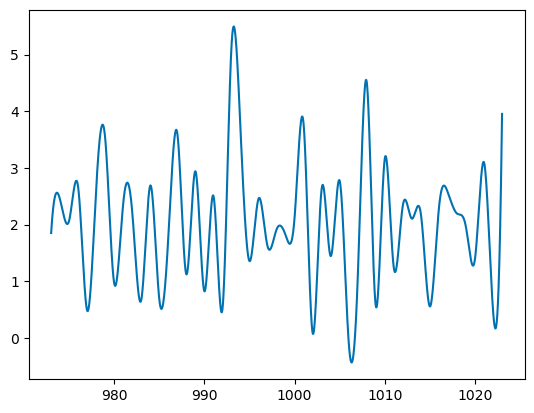

In [55]:
plt.plot(t, tt(t, reconstructed, coarse))
plt.show()

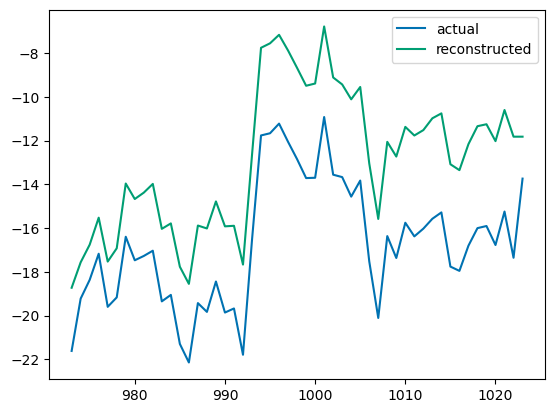

In [57]:
plt.plot(coarse, data) 
plt.plot(coarse, vals2 + jnp.average(data[0:4])) 
plt.legend(['actual', 'reconstructed'])
plt.show()

In [60]:
data - vals2 - jnp.average(data[0:4])

DeviceArray([-2.88940501, -1.66055534, -1.609133  , -1.64921979,
             -2.06992842, -2.2457162 , -2.43428688, -2.80202052,
             -2.89627822, -3.05552091, -3.31731152, -3.26896311,
             -3.53099785, -3.59557008, -3.54704195, -3.81563655,
             -3.66211961, -3.9428256 , -3.78045056, -4.12477143,
             -3.88197823, -4.00894903, -4.11410266, -4.06144715,
             -4.17602627, -4.17434888, -4.22238156, -4.31047029,
             -4.14205439, -4.4465711 , -4.23765409, -4.45047694,
             -4.27931986, -4.47969464, -4.52887528, -4.30972169,
             -4.63847215, -4.38456835, -4.61370232, -4.50685399,
             -4.5953801 , -4.52890972, -4.68037524, -4.60664298,
             -4.64448281, -4.66177404, -4.65452324, -4.75048227,
             -4.64386601, -5.53735396, -1.91770603], dtype=float64)